# 3D Double Integrator

## Environment Definition

In [6]:
import logging

import numpy as np

from do_ddpc.control_utils.lti_systems import create_3D_double_integrator

# Removes the INFO logging
logging.getLogger().setLevel(logging.WARNING)

noise_config = {"meas_noise_std": np.array([0.005]), "meas_noise_seed": 6473}

env = create_3D_double_integrator(**noise_config)

## Training Data Collection

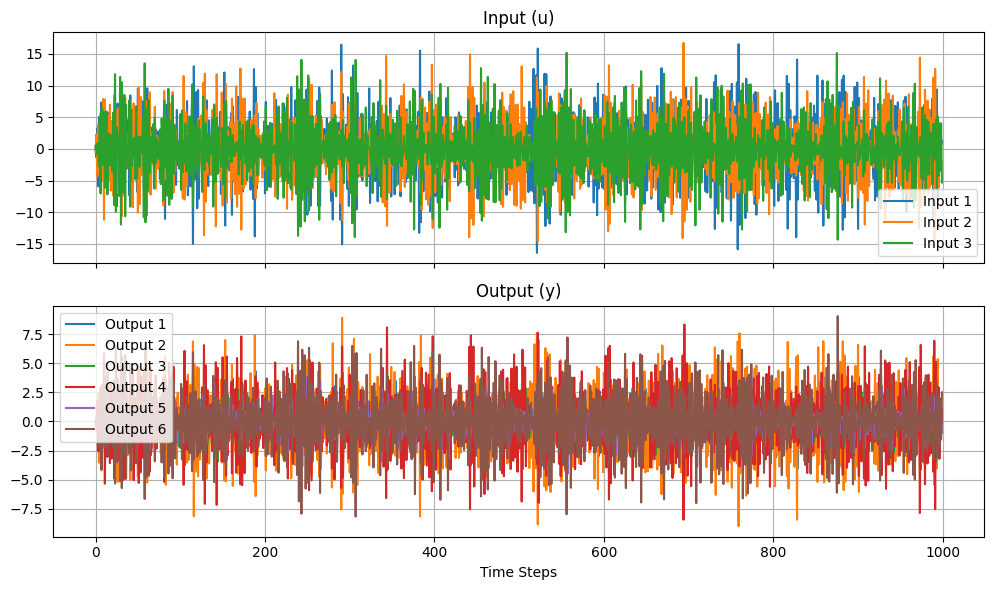

In [7]:
from do_ddpc.control_utils.trajectory_collector import collect_trajectory_data
from do_ddpc.control_utils.pid_profiles import THREE_D_DOUBLE_INT_PID_COMBO
from do_ddpc.utils.plots import plot_training_data

n_samples = 1000

pid_combo = THREE_D_DOUBLE_INT_PID_COMBO

_, m, p = env.get_dims()
training_data = collect_trajectory_data(env, m, p, pid_combo)

plot_training_data(training_data)

## Online DPC Application

In [8]:
from tqdm import tqdm
from do_ddpc.control_utils.trajectory_collector import TrajectoryCollector
from do_ddpc.control_utils.control_structs import Bounds
from do_ddpc.ddpc.tpc import TPC
from do_ddpc.ddpc.ddpc_structs import DPCParameters

n_sim = 10
traj_col = TrajectoryCollector(m, p, n_sim)
ddpc_params = DPCParameters(Q=np.diag([100, 1, 100, 1, 100, 1]), R=0.001 * np.eye(3), tau_p=3, tau_f=3)

ctrl_inst = TPC(ddpc_params, training_data)

ctrl_inst.build_optimization_problem()

y_r = np.array([7, 0, 7, 0, 7, 0])
u_r = np.zeros((3,))
ctrl_inst.update_tracking_reference(y_r, u_r)

u_next, y_current, y_prev = np.zeros((m,)), env.step(np.zeros((m,))), env.step(np.zeros((m,)))

for _ in tqdm(range(n_sim), desc="Running Simulation", ncols=80):
    traj_col.store_measurements(y_prev, u_next)
    z_p_current = np.concatenate((y_prev, u_next))
    ctrl_inst.update_past_measurements(z_p_current)
    ctrl_inst.solve()
    u_next = ctrl_inst.get_next_control_action()
    y_prev, y_current = y_current, env.step(u_next)

sim_data = traj_col.get_trajectory_data()
print("Running of the DPC algorithm complete")

Running Simulation: 100%|█████████████████████| 10/10 [00:00<00:00, 6269.51it/s]

Running of the DDPC algorithm complete


## Analyse and Data Visualization

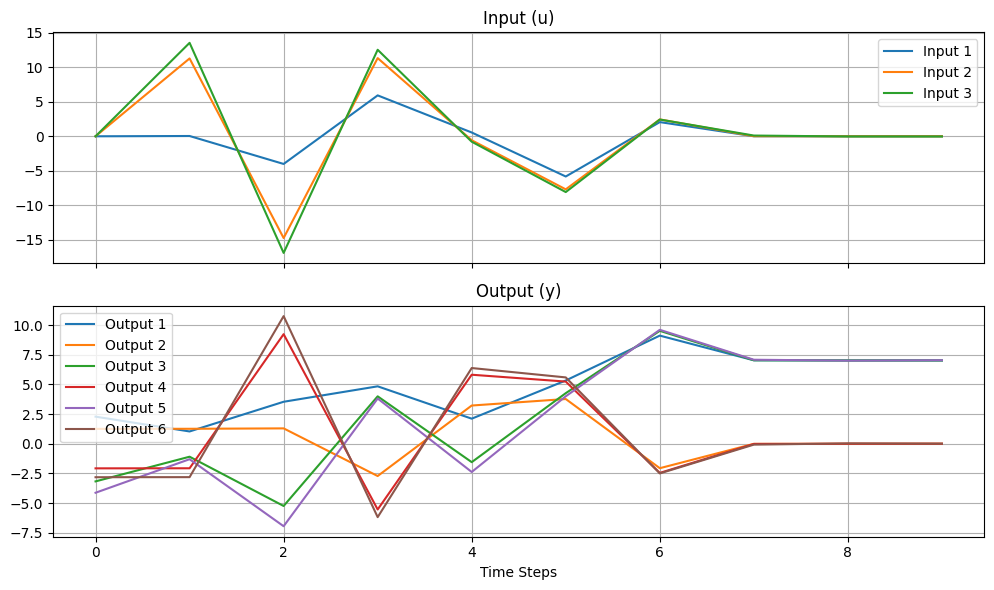

In [9]:
plot_training_data(sim_data)